# Extracting polygons from shapefiles

When dealing with polygon data in a shapefile, you may want to find the relative pixel locations of the polygons to the overall raster files. This can be done using `ogr` and the `gdal` library

References: 
- https://automating-gis-processes.github.io/2016/Lesson2-geopandas-basics.html
- https://software.intel.com/en-us/blogs/2017/09/08/pre-processing-geotiff-files-and-training-deepmasksharpmask-model


In [3]:
from osgeo import gdal,ogr
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import fiona
import rasterio
import rasterio.plot

In [4]:
shp = '/efs/data/jpb/data/tiles/raw_data/bboxes/IDP_Dana_BufferSquare2.shp'
raster = '/efs/data/jpb/data/tiles/raw_data/images/Dana_IDPs_20190606.tif'

## Initial overview

In [5]:
gdf = gpd.read_file(shp)

In [7]:
gdf.crs

{'init': 'epsg:4326'}

In [68]:
src = rasterio.open(raster)

In [69]:
src.crs

CRS({'init': 'epsg:3857'})

**Note:** CRS are different -> convert shapefile

In [70]:
gdf_new = gdf.to_crs({'init': 'epsg:3857'})

In [71]:
gdf_new.head()

,Site_ID,Sensor_ID,Sensor_Dat,Confidence,Field_Vali,CampStatus,CampName,Notes,GlobalID,StaffID,EventCode,CampType,CampTrend,Shelter_St,ShelterClo,Structure_,BUFF_DIST,ORIG_FID,geometry
0,1,2,2019-06-06,2,0,1,Qah and Liyajlikum,None,{C5E9E5C8-1E7B-453D-930F-2259C98A5E7D},141,CE20130604SYR,2,0,1,None,1,4.0,0,"POLYGON ((4084739.724123693 4341406.058858634,..."
1,1,2,2019-06-06,2,0,1,Qah and Liyajlikum,None,{F55B75B7-0760-4842-9CED-2FAA5CD20282},141,CE20130604SYR,2,0,1,None,1,4.0,1,"POLYGON ((4084741.311645375 4341418.229725038,..."
2,1,2,2019-06-06,2,0,1,Qah and Liyajlikum,None,{54308900-2511-4327-BFD5-F633A68D37AE},141,CE20130604SYR,2,0,1,None,1,4.0,2,"POLYGON ((4084723.981430853 4341409.895375458,..."
3,1,2,2019-06-06,2,0,1,Qah and Liyajlikum,None,{434915B8-378F-4DA4-896A-C9AC3CAB575F},141,CE20130604SYR,2,0,1,None,1,4.0,3,"POLYGON ((4084725.436593543 4341422.330881506,..."
4,1,2,2019-06-06,2,0,1,Qah and Liyajlikum,None,{901A00F0-ECC7-46BF-B6D1-A5AE521F03CB},141,CE20130604SYR,2,0,1,None,1,4.0,4,"POLYGON ((4084730.728400237 4341396.004807143,..."


## Extract information

In [77]:
g = gdf_new['geometry']
all_coords = []
for j in range(len(g)):
    coord = []
    for i in g[j].boundary.coords:
        coord.append(i)
    all_coords.append(coord)

In [112]:
def world2Pixel(geoMatrix, x, y):
    """
    Uses a gdal geomatrix (.transform) to calculate
    the pixel location of a geospatial coordinate
    """
    ulX = geoMatrix[2]
    ulY = geoMatrix[5]
    xDist = geoMatrix[0]
    yDist = geoMatrix[4]
    rtnX = geoMatrix[1]
    rtnY = geoMatrix[3]
    pixel = int((x - ulX) / xDist)
    line = int((ulY - y) / xDist)
    return (pixel, line)

In [115]:
gt = src.transform

In [116]:
pixel_coords = []
for i in all_coords:
    coords = []
    for j in i:
        coords.append(world2Pixel(gt,j[0],j[1]))
    pixel_coords.append(coords)

In [118]:
pc = np.array(pixel_coords)

In [127]:
pc.shape

(14623, 5, 2)

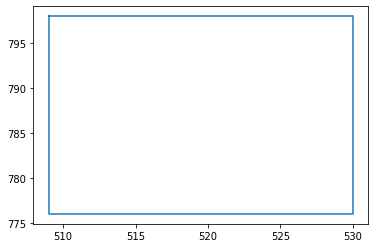

In [125]:
plt.plot(pc[0,:,0],pc[0,:,1])

# OLD GDAL METHODS

In [8]:
ds = ogr.Open(shp)

In [9]:
lyr = ds.GetLayer()

In [10]:
lsx=[]
lsy=[]
# here we get shelter type
shelter = []
for feat in lyr:
    geom = feat.GetGeometryRef() # get geo-referenced location
    pts = geom.GetGeometryRef(0)
    px = []
    py = []
    for i in range(pts.GetPointCount()):
        px.append(pts.GetX(i))
        py.append(pts.GetY(i))
    lsx.append(px[:-1]) # remove first point due to these boxes having 5 points
    lsy.append(py[:-1])

Check bounding box shapes

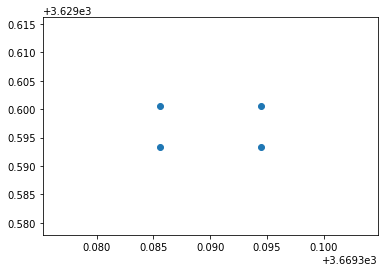

In [11]:
plt.scatter(np.array(lsx[1])*100, np.array(lsy[1])*100)
plt.show()